# Accelerating Fluid Simulation with Convolutional Networks 


## 0 Introduction and context

Efficient simulation of the Naver-Stokes equations for fluid flow is a long standing problem in applied mathematics for which traditional methods require large compute ressources.

However, in many use-cases, the exact solution is not needed. A fast/real-time computation whith highly realistic simulations is sufficient (in movies or video games for examples).

This notebook aims to present recent and promising methods using convolutional networks to reach fast realistic simulations.

- We begin by explaining the classic projection method for solving Navier-Stokes equations to better understand how it can be improved.
- Then, we delve into Jonathan Tompson et al.'s 2013 approach, [Accelerating Eulerian Fluid Simulation with Convolutional Networks](https://arxiv.org/abs/1607.03597), showcasing significant improvements in solving times. 
- Recognizing limitations, we subsequently introduce a more promising 2021 method by Nils Wandel et al., detailed in [Teaching the Incompressible Navier-Stokes Equations to Fast Neural Surrogate Models in 3D](https://arxiv.org/abs/2012.11893), which effectively overcomes drawbacks encountered in the earlier approach.


### Warning
Setting up and installing the code for running simulations directly on this notebook is quite challenging. To facilitate accessibility and prevent excessive length, links to the code are provided throughout the notebook for independent checking
 Additionally, if you wish to execute the simulations, the associated Git repositories are included.


## Navier-Stokes equations
When a fluid has zero viscosity and is incompressible, it can be modeled by Euler equations (1967):

\begin{align*}
\frac{\partial \mathbf{v}}{\partial t} + (\mathbf{v} \cdot \nabla)\mathbf{v} &= -\nabla p + \mathbf{f} \quad (1) \\
\nabla \cdot \mathbf{v} &= 0 \quad (2)
\end{align*}

Where  $\mathbf{v}$ = (u, v, w)  is the velocity field, $\mathbf{f}$ accounts for the external forces, and p the pressure.
Equation (1) is the momemtum equation resulting from Newton's second low and equation (2) descibes the incompressibility condition.


## 1 Projection method
To solve Navier-Stokes equations, an algorithm called 'Projection method' is widely used.
Introduced by Alexandre Chorin (1967), its principle is to compute the velocity and the pressure fields in two decoupled steps.
This algorithm relies on Helmholtz–Hodge decomposition.

### 1.1 Helmholtz–Hodge decomposition
<div class="alert alert-success">
    
**Theorem: Helmholtz–Hodge decomposition**

Theorem: A vector field $\mathbf{v}$ defined on a simply connected domain can be uniquely decomposed into a divergence-free (solenoidal) $\mathbf{v}_{\mathbf{sol}}$ and an irrotational part $\mathbf{v}_{\mathbf{irrot}}$ [1]

Thus,
\begin{align*}
\mathbf{v} = \mathbf{v}_{\mathbf{sol}} + \mathbf{v}_{\mathbf{irrot}} = \nabla \times a + \nabla \Phi
\end{align*}
</div>

Since $\nabla \times \nabla \Phi = 0$ for any scalar function, the divergence of the equation gives:

$\nabla \cdot \mathbf{v}$ = $\nabla^2 \phi$ (since $\nabla \cdot \mathbf{v}_{\mathbf{sol}} =0$)

This is a Poisson equation for the scalar function $\Phi$ and if the vector field $\mathbf {v}$ is known, the above equation can be solved for the scalar function $\Phi$.

The main outcome is that the divergence-free part of $\mathbf {v}$, $\mathbf{v}_{\mathbf{sol}}$, can be extracted using the relation:

$\mathbf{v}_{\mathbf{sol}}$= $\mathbf{v}$ - $\nabla \Phi$

This decomposition is the essence of Chorin's projection method. Let's see how it can be applied to Navier-Stokes equations.

### 1.2 Chorin's projection method to solve Navier-Stokes equations

Chorin introduced a method to solve Euler equations (1) and (2) using this decomposition to find the divergence-free velocity field.

The method is in two steps:
1. Compute a intermediate velocity, $\mathbf{v}^{\mathbf{*}}$, ignoring the pressure term of Equation (1) ($-\nabla p$) to create a velocity including unwanted divergence:
\begin{align*}
\frac{\mathbf{v}^{\mathbf{*}} - \mathbf{v}}{\Delta t} + \mathbf{v} \cdot \nabla \mathbf{v} = \mathbf{f} \quad (3)
\end{align*}
3. Correct the intermediate velocity to make it divergence-free and obtain the final solution:
\begin{align*}
\mathbf{v} = \mathbf{v}^{\mathbf{*}} - \Delta t \nabla p \quad (4)
\end{align*}

Solving Equation (4) therefore requires the knowledge of the pressure p which is obtained by solving the following Poisson equation: 

\begin{align*}
\nabla^2 p = \frac{\nabla \cdot \mathbf{v}^{\mathbf{*}}}{\Delta t} \quad (5)
\end{align*}

Lets check that $\nabla \cdot \mathbf{v} = 0$.

Equation (5) leads to $\nabla \cdot (\mathbf{v}^{\mathbf{*}} - \Delta t \nabla p) = 0$ which gives to $\nabla \cdot \mathbf{v} = 0$ with Equation (4).

Therefore, equation (4) is the standard Hodge decomposition of $\mathbf{v}^{\mathbf{*}}$: 
$\mathbf{v}^{\mathbf{*}} = \mathbf{v} + \Delta t \nabla p$

In this method, solving the Poisson equation (5) is by far the most computationally demanding step.

### 1.3 Classical method to solve the Poisson equation (5)

The right hand of equation (5),$\nabla \cdot \mathbf{v}^{\mathbf{*}}$, is considered knowned because it can be calculated using Green-Ostrogradski's theorem:

<div class="alert alert-success">

**Divergence theorem**
\begin{align*}
V_{\text{cell}} \nabla \cdot \mathbf{v}^{\mathbf{*}} = \sum_{\text{faces}} (\mathbf{v}^*_{\text{face}} \cdot \mathbf{n}) A_{\text{face}} \quad (6)
\end{align*}
</div>

where $V_{\text{cell}}$ is the volume of a cell, $\mathbf{n}$ is the outward unit normal of the cell and $A_{\text{face}}$ represents faces of the cell.

For the figure below, the discretization of the x component $\frac{\partial v^*}{\partial x}$ of the divergence is:
\begin{align*}
\Delta x \Delta y \Delta z \frac{\partial \mathbf{v}^*}{\partial x} = u^*_2 A_2 - u^*_1 A_1
\end{align*}

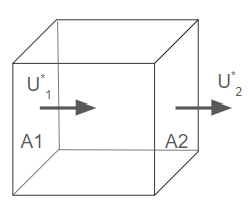

So Equation (5) boils down to solve a Poisson equation: 
\begin{align*}
\Delta p = g
\end{align*}

Let's demonstrate that solving this equation using finite differences method leads to solve a linear equation $A\mathbf{u'}=\mathbf{b}$.

In case of of the 2-dimentional case:
\begin{align*}
\Delta p = \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}
\end{align*}

Assuming a uniform spatial discretization ($\Delta x = \Delta y$) on $m*n$ grid, the Laplace operator can be approximated by the second order approximation:

\begin{align*}
\Delta p = \frac{p_{i+1,j} - 2p_{i,j} + p_{i-1,j}}{\Delta x^2} + \frac{p_{i,j+1} - 2p_{i,j} + p_{i,j-1}}{\Delta x^2}
\end{align*}

So
\begin{align*}
\Delta  p_{i,j} = \frac{p_{i+1,j} + p_{i-1,j} + p_{i,j+1} + p_{i,j-1} - 4p_{i,j}}{\Delta x^2} = g_{i,j}
\end{align*}

with appropriate boundary conditions, let's order ne the $N = m * n$ grid with a signle index $k$ from 1 to $N$

\begin{align*}
\mathbf{u'} = \begin{bmatrix} p_{11}, p_{21}, \ldots, p_{m1}, p_{12}, p_{22}, \ldots, p_{m2}, \ldots, p_{mn} \end{bmatrix}^{\mathsf{T}}
\end{align*}

This result in a $m*n$ linear system:
\begin{align*}
A\mathbf{u'}=\mathbf{b} \quad (7)
\end{align*}

with 
\begin{align*}
\mathbf{b} = -\Delta x^{2}\begin{bmatrix} g_{11}, g_{21}, \ldots, g_{m1}, g_{12}, g_{22}, \ldots, g_{m2}, \ldots, g_{mn} \end{bmatrix}^{\mathsf{T}}
\end{align*}

A = \begin{bmatrix}
D & -I & 0 & 0 & 0 & \cdots & 0 \\
-I & D & -I & 0 & 0 & \cdots & 0 \\
0 & -I & D & -I & 0 & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & -I & D & -I & 0 \\
0 & \cdots & \cdots & 0 & -I & D & -I \\
0 & \cdots & \cdots & \cdots & 0 & -I & D
\end{bmatrix}

$I$ is the $m*n$ identify matrix and $D$ is the $m*m$ matrix given by:

D = 
\begin{bmatrix}
4 & -1 & 0 & 0 & 0 & \cdots & 0 \\
-1 & 4 & -1 & 0 & 0 & \cdots & 0 \\
0 & -1 & 4 & -1 & 0 & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & -1 & 4 & -1 & 0 \\
0 & \cdots & \cdots & 0 & -1 & 4 & -1 \\
0 & \cdots & \cdots & \cdots & 0 & -1 & 4
\end{bmatrix}

This linear system has a large number of free parameters so a large  number of iterations must be performed with standard iterative solvers. In real-time applications, PCG or Jacobi iterations are truncated before reaching convergence.
**As the truncation doesn't ensure the incompressibility condition, the otbained velocity fields may be divergent on the long run.**


Therefore, the goal of this notebook is to see if machine learning can provide an alternative approach to speed up Navier-Stokes equations while keeping a solution with low long-term divergence.


## 2 Using Convolutional Networks to solve Poisson Equation

First we could try to use a powerful regressor such as a neural network to directly estimate the velocity field at each time-stem. However, the chaotic change of velocity between frames is higly unstable and easily affected by external forces and other factors, making it not effective.

As solving the linear system in Poisson equation is costly, one can attempt to approximate it using a deep neural network. Jonathan Tompson et al. first introduced a convolutional network to try to solve this problem [3]. 

### 2.1 Introducing a divergence loss as an unsupervised machine learning problem
As the goal is to estimate a divergence-free velocity, we can try to see this problem as a unsupervised machine learning problem.
Indeed, instead of measuring some loss which would be a distance between next frame predicted velocity and the true one, we can introduce the L-2 norm of the divergence of the predicted velocity to minimize it directly.

<div class="alert alert-success">

**Divergence Loss**
\begin{align*}
f_{\text{obj}} = \sum_{i} w_i \left\{ \nabla \cdot \hat{u}_t \right\}_i = \sum_{i} w_i \left\{ \nabla \cdot \left( \mathbf{u}^*_t - \frac{1}{\rho} \nabla \hat{p}_t \right) \right\}_i^2 \quad (7)
\end{align*}
Where $\hat{u}_t$ and $\hat{p}_t$ are predicted divergence free velocity and pressure fields and $w_i$ is a weighting term to emphasize the divergence on boundaries. $w_i$ is defined as below:
\begin{align*}
w_i = max(1, k-d_i)
\end{align*}
$d_i$ is the minimum Euclidian distance of each fluid-cell to the nearest solid cell.

However, as the fluid solid-border represents a small fraction of the domain, $w_i$ has only a minor contribution to the simulation.
</div>

The keys improvement of using a neural network and $f_{\text{obj}}$ as the loss is that the ground-truth velocity from extensive methods is no longer necessary. Moreover, the loss can be computed after several time-steps to better reduce long term divergence. During the training, the simulation is forwarded from $u_0$ to to $u_n$ for each sample. Then, $f_{\text{obj}}$ is calculated using Equation (7) as described below.

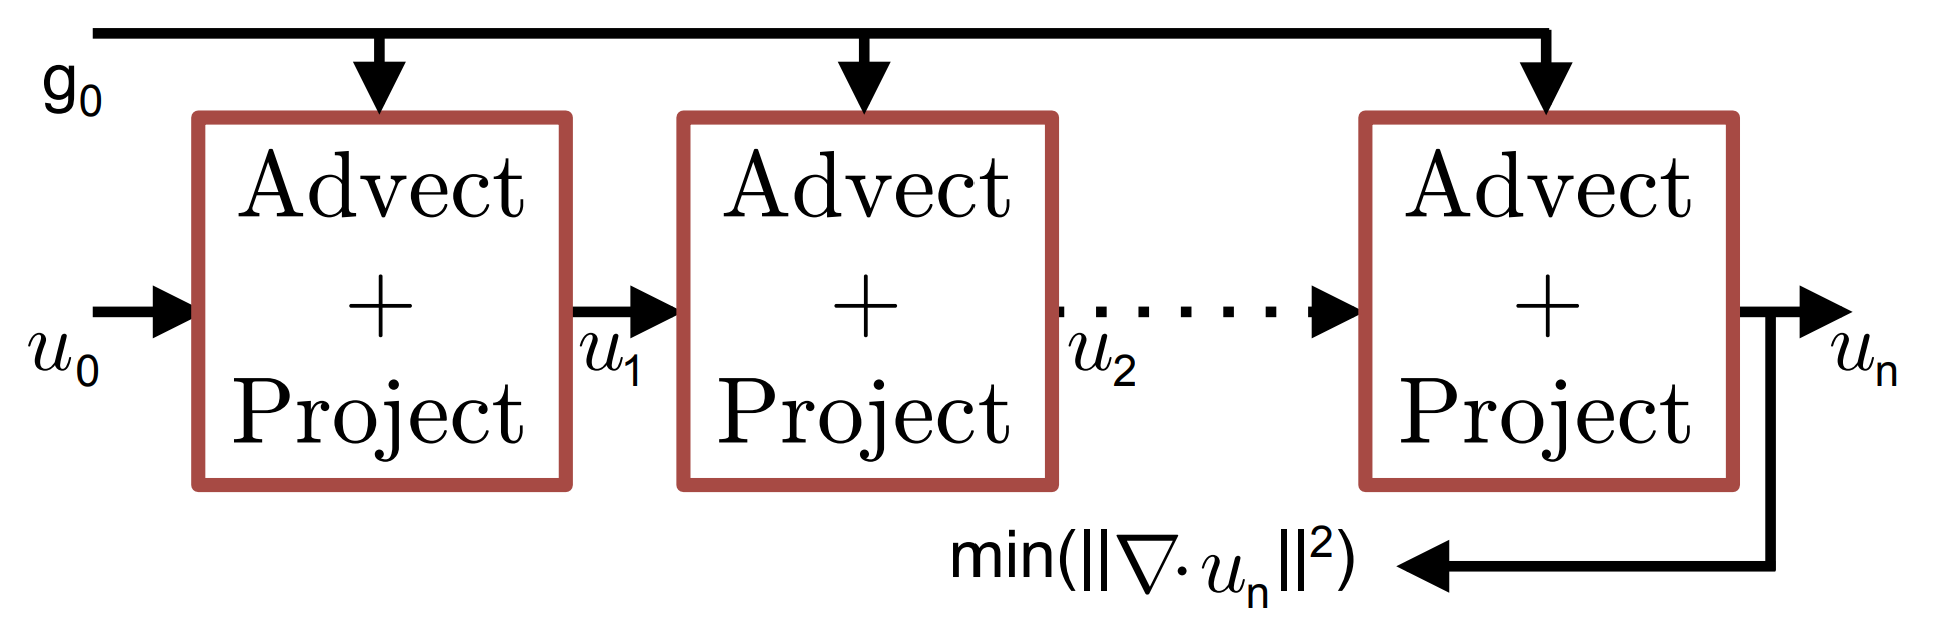


On this graph, $g_t$ is the geometry field (a Boolean grid to state whether cells are fluids are solid).
Then, Back Propagation is used to optimize the weights and biases, $c$ of the neural netwok.

Using a neural network also allows to carry out data augmentation and as a linear system, we can normalize the input to help training and predictions

The velocity-update is done through Chorin's algorithm using $f_{\text{conv}}$, the convolutional network, to estimate the pressure in the Poisson equation (5).

Here is the breakdown of the algorithm:

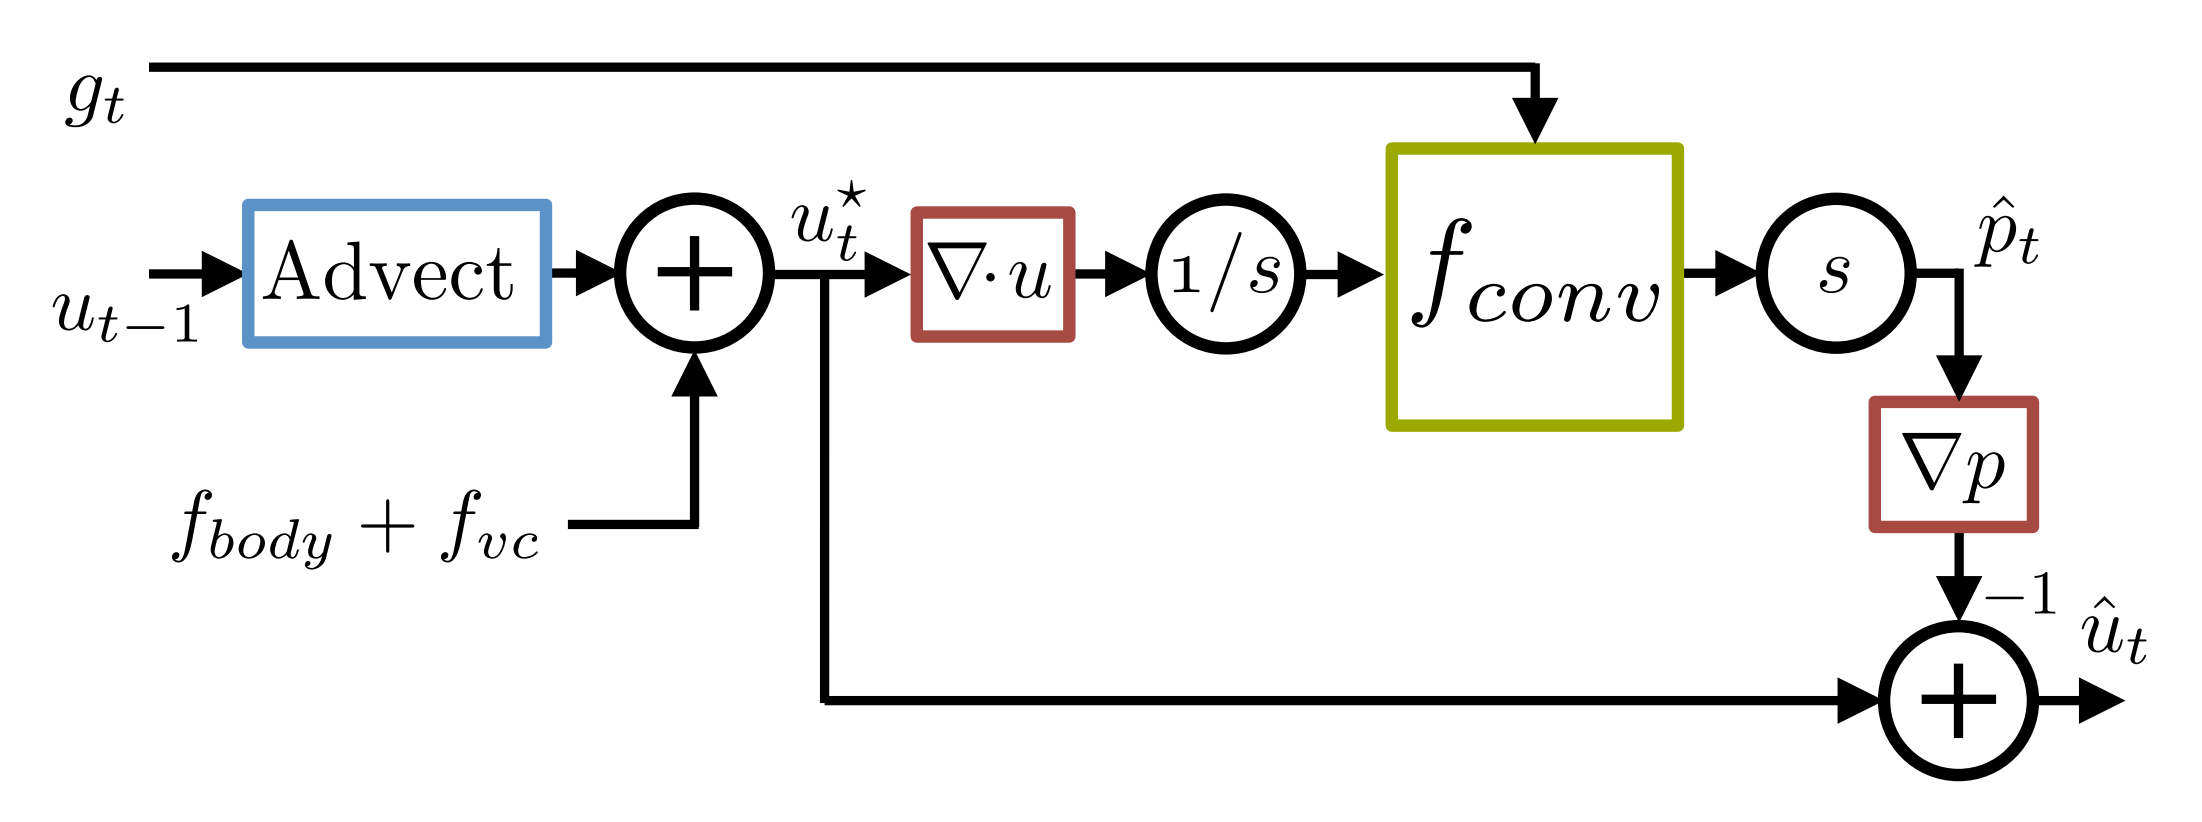

where $s = STD(u_t^*)$ scales the inputs.
Please, note that the only block with trainable parameters is the CNN and that all blocks are differentiable.

The initial CNN intropduced by Jonathan Tompson et al. is composed of 5 stages of convolution and rectifying layer. As a single resolution network would have limited context which limits the network's ability to model long-range external forces (e.g. gravity etc.) multi-resolution features are added to these phenomenon by downsampling the first hidden layer twice using average pooling. 

Here is an illustration of the CNN:

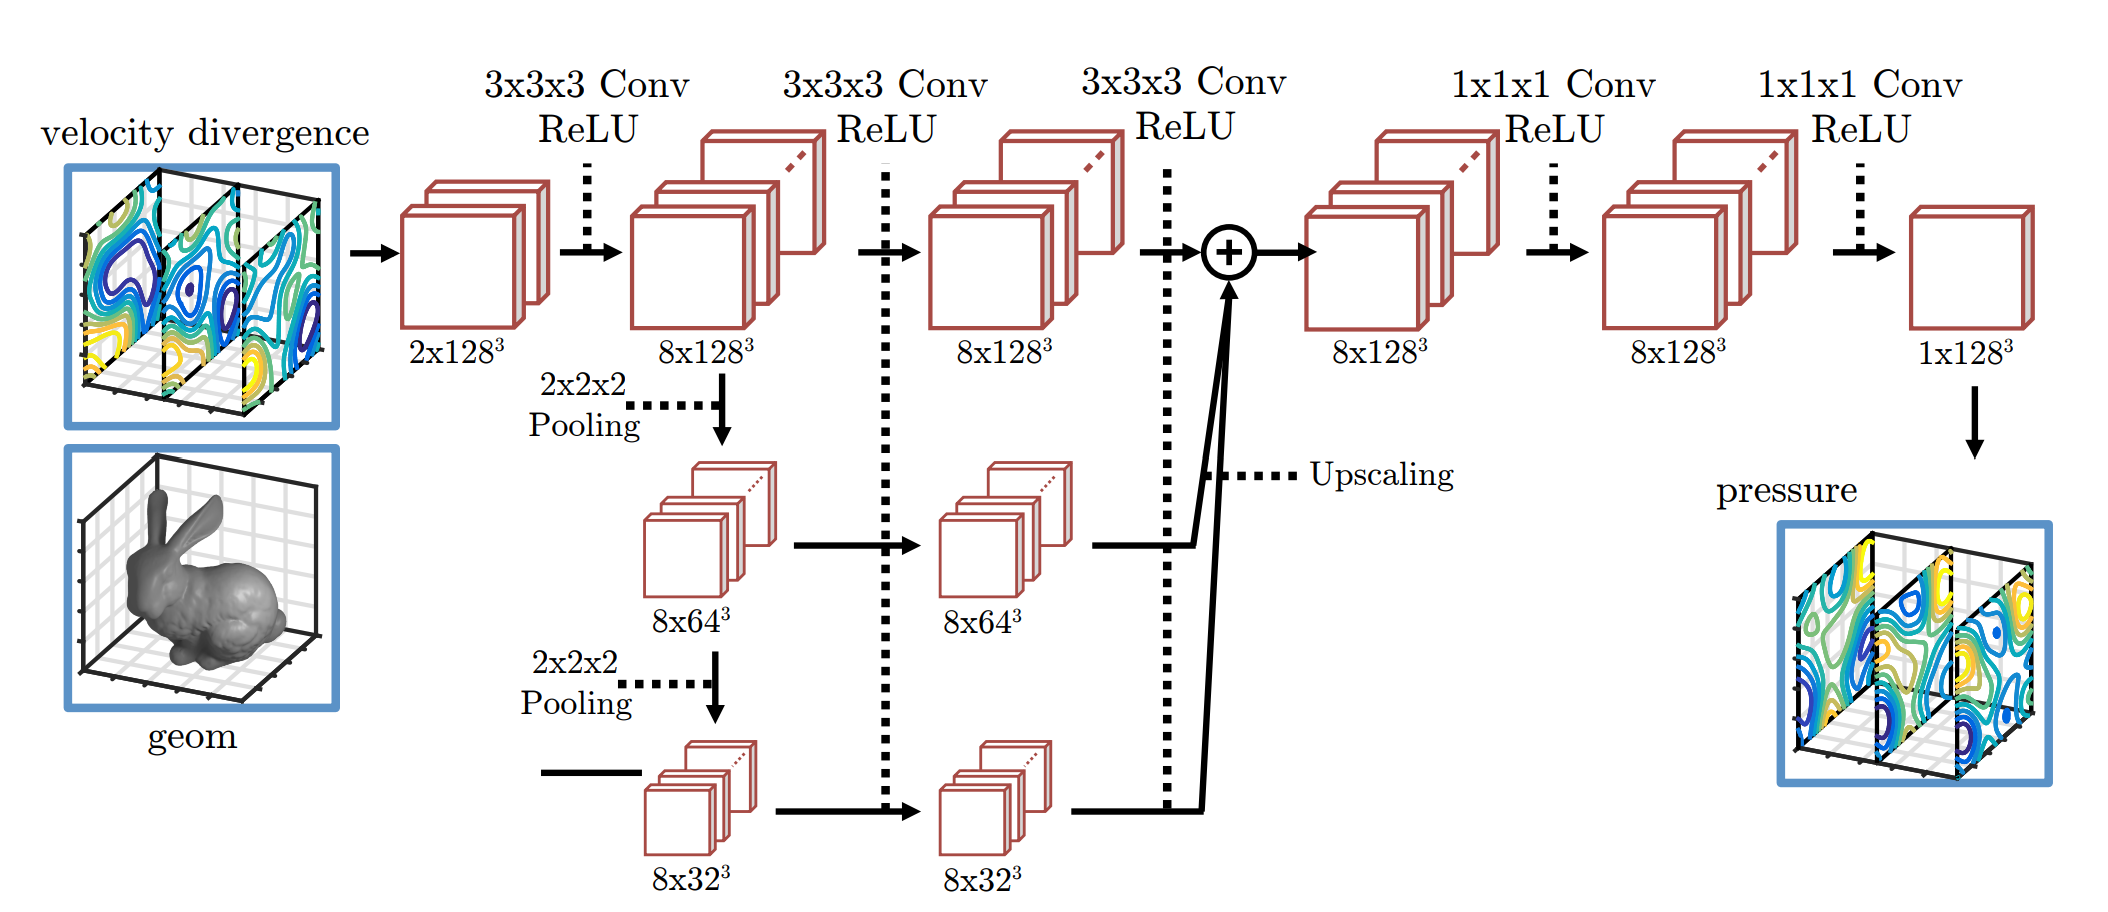

It is important to say that the model proposed can indeed be improved with (for example with residual connections or gated convolutions). But overall, the purpose of using machine learning to solve Navier-Stokes equation is to make it faster and allow to compute the simulation in real-time. The model improvements suggested indeed improve accuracy but lead to longer run-time. It is a trade-off between accuracy and run-time.

### 2.2 The complexity of traning
Even though label information are not required to train the network. Training is complicated which is a big disadvantage of this method. The network's generalization performance improves when using a dataset that approximately samples the manifold of real-world fluid states.

Indeed, to train the network, synthetic data are generated using an offline 3D solver (sucha as Mantaflow). This makes this method solver-dependant.
Here is the routine to create a dataset:

1. A pseudo-random divergence free velocity field is initialized
2. An occupacy grid is initialized by randomly selecting 3D objects and randomly sclaing, rotating and translating these in the domain
3. Input divergent perturbations are added
4. Manta is used to calculate $u_t^*$  (advecting velocity field and adding external forces)

### 2.3 Promising results

Let's see the how this simulation looks like comparing to classic solvers (PCG and Jacobi).
Here is a rendred frame of a plume simulation, the boundary condition is not present in the training set and presents an input divergent flow 5 times wider than the largest impulse present during training.

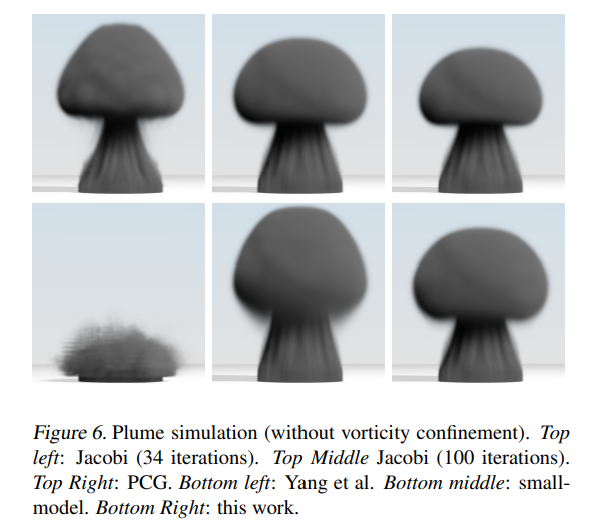

You can see that the the early truncated Jacoby method (top-left) has an elongated shape due to incorrect modeling of bruoyancy forces.

However, the PCG solver, the 100 iteration Jacobi solver and this model produce visually similar results which is promising.

Moreover, in term of run-time, at fixed computing capacity, the times of Jacobi and fluid-net methods are equivalent. PCG runtimes have been removed of the graph for clarity because it is much more slower.

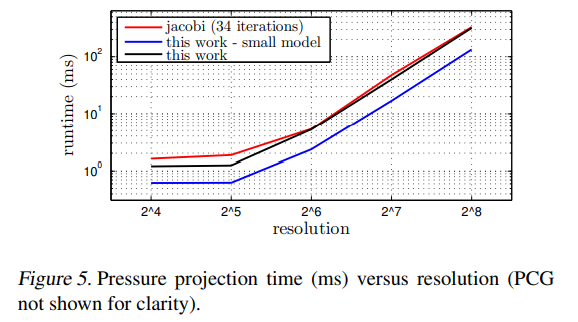


You can access the code of this algorithm and try to install it on your machine following instructions in this [git repository](https://github.com/google/FluidNet).

## 3 Using Convolutional Networks to build surrogate models


The approach by Tompson et al., showcased the possibility to use CNNs to advance a fluid state in time efficiently and to generalize well to new domain geometries not contained in the training set. 

However, this method has some drawbacks. It cannot handle viscous fluids and dynamic boundary conditions and it relies on the availability of training data from fluid simulations such as FEniCS, OpenFOAM or Mantaflow. Moreover, even if the loss chosen is L-2 norm of the divergence of the predicted velocity, it still not prevent the velocity from having divergence on the long run and it comes at high computational costs. 


Therfore, let's introduce a more recent method in particular introduced by Nils Wandel in 2021 [4]. This method solves Navier-Stokes using CNNs from a different perspective, creating a surrogate model. 

### 3.1 Predicting the potential velocity field to ensure incompressibility


Let's get back to the momentum equation from Navier-Stokes with viscosity $\mu $:


\begin{align*}
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} &= \mu \Delta \mathbf{u} -\nabla p + \mathbf{f} \quad (8)
\end{align*}

Hodge decomposition introduced at the beginning allows to write :
\begin{align*}
\mathbf{u} = \mathbf{u}_{\mathbf{sol}} + \mathbf{u}_{\mathbf{irrot}} = \nabla \times \mathbf{a} + \nabla \Phi 
\end{align*}

So we can write $\mathbf{u}_{\mathbf{sol}} = \nabla \times \mathbf{a}$. Of course $\nabla \times \mathbf{a}$ is divergence-free $( \nabla \cdot (\nabla \times \mathbf{a}) = 0 )$

**A new way to model the fluid is to directly predict $\mathbf{a}$, because this guarantees incompressibility of the velocity field**. The velocity field can then be calculated using $\nabla \times \mathbf{a}$.

In order to process the fluid state with a 3D convolutional neural network, we consider the following spatial and temporal discretizations:

\begin{align*}
\mathbf{a} = \begin{bmatrix} (a_x)_t^{i,j,k} \\ (a_y)_t^{i,j,k} \\ (a_z)_t^{i,j,k} \end{bmatrix} ; \quad \mathbf{v} = \begin{bmatrix} (v_x)_t^{i,j,k} \\ (v_y)_t^{i,j,k} \\ (v_z)_t^{i,j,k} \end{bmatrix} ; \quad p = p_t^{i,j,k}
\end{align*}


To represent relationship between $\mathbf{a}, \mathbf{v}$ and $p$, the fluid is discretized on a Marker-And-Cell (MAC) grid like this:

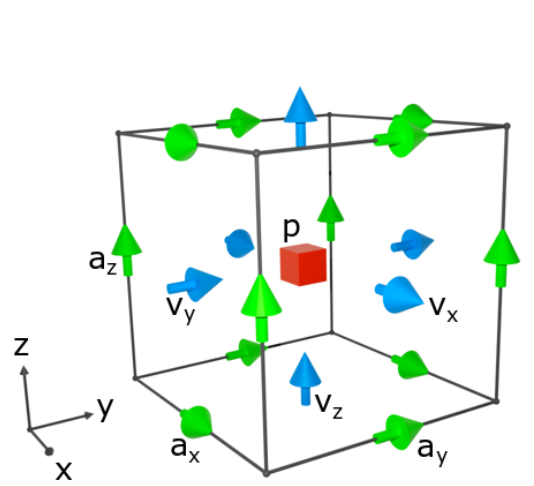

This representation allows to easily calculate $\mathbf{a}$ and $\nabla \cdot \mathbf{v}$:

\begin{align*}
\begin{bmatrix}
(v_x)_{i,j,k} \\
(v_y)_{i,j,k} \\
(v_z)_{i,j,k}
\end{bmatrix} =
\begin{bmatrix}
(a_z)_{i,j+1,k} - (a_z)_{i,j,k} - (a_y)_{i,j,k+1} + (a_y)_{i,j,k} \\
(a_x)_{i,j,k+1} - (a_x)_{i,j,k} - (a_z)_{i+1,j,k} + (a_z)_{i,j,k} \\
(a_y)_{i+1,j,k} - (a_y)_{i,j,k} - (a_x)_{i,j+1,k} + (a_x)_{i,j,k}
\end{bmatrix}
\end{align*}

\begin{align*}
\nabla \cdot \mathbf{v}_{i,j,k} = (v_x)_{i+1,j,k} - (v_x)_{i,j,k} + (v_y)_{i,j+1,k} - (v_y)_{i,j,k} + (v_z)_{i,j,k+1} - (v_z)_{i,j,k}
\end{align*}

### 3.2 Introducing a Physics-Informed Loss Function to solve Navier-Stokes equations
Since incompressibility is now guaranteed by predicting $\mathbf{a}$, the Loss function defined above (7) is no longer useful.
As we are going to directly predict the fluid state in $t+dt$ given its state in $t$, we introduce a new loss to ensure momemtum equation (8):
<div class="alert alert-success">

**Navier-Stokes Loss**

\begin{align*}
L_p = \rho \| \frac{\mathbf{v}_{t+dt} - \mathbf{v}_t}{dt} + \nabla \cdot \left( \mathbf{v}_{t'} \cdot \nabla \mathbf{v}_{t'} \right) + \nabla p_{t+dt} - \mu \nabla \cdot (\Delta \mathbf{v}_{t'}) - \mathbf{f} \|^2 \text{ in } \Omega \quad (9)
\end{align*}
</div>

where $\Omega$ is the domain and $\partial \Omega$ the boundary of the domain.

Furthermore, Dirichlet boundary conditions at the boundary of the domain must also be verified to match initial condition:
\begin{align*}
\mathbf{v} = \mathbf{v}_d \text{ on } \partial\Omega \quad (10)
\end{align*}

Therefore, we introduce a new boundary loss term:
<div class="alert alert-success">

**Bounday-conditions Loss**

\begin{align*}
L_b = \|\mathbf{v}_{t+dt} - \mathbf{v}_{t-dt}\|^2 \text{ on } \partial \Omega \quad (11)
\end{align*}
</div>

Combining these two loss functions, we otbain the following loss one:
<div class="alert alert-success">

**Physics-informed Loss**

\begin{align*}
L = \alpha L_p + \beta L_b \quad (12)
\end{align*}
</div>


$\alpha$ and $\beta$ are hyperparameters to weights the differents loss terms. ($\alpha=1$ and $\beta=20$ were originally chosen in [TEACHING THE INCOMPRESSIBLE NAVIER-STOKES EQUATIONS TO FAST NEURAL SURROGATE MODELS IN 3D](https://arxiv.org/abs/2012.11893))

### 3.3 Using CNN to create a surrogate model

This new approach is now to create a full model of the fluid dynamics, $F$ to predict the state of the fluid on the next time step $t+dt$. To do so, we only need $\mathbf{a}_t, p_t$, fluid parameters $\mu_{t+dt}, \rho_{t+dt}$, the domain $\Omega_{t+dt}$ and boundary conditions $\mathbf{v}_{t+dt} = \mathbf{v}_{t+dt}^d$.

Therefore we have: 
\begin{align*}
(\mathbf{a}, p)_{t+dt} = F((\mathbf{a}, p)_t, \Omega_{t+dt}, \mathbf{v}_{t+dt}^d, \mu_{t+dt}, \rho_{t+dt}) \quad (13)
\end{align*}

By reccurrently applying $F$ on the initial fluid state $(\mathbf{a}_0, p_0)$, the fluid simulation can be unrolled.

Two CNN models have been implemented by Nils Wandel et al. to compare the accuracy/speed trade-off.  The twos architectures are displayed below:

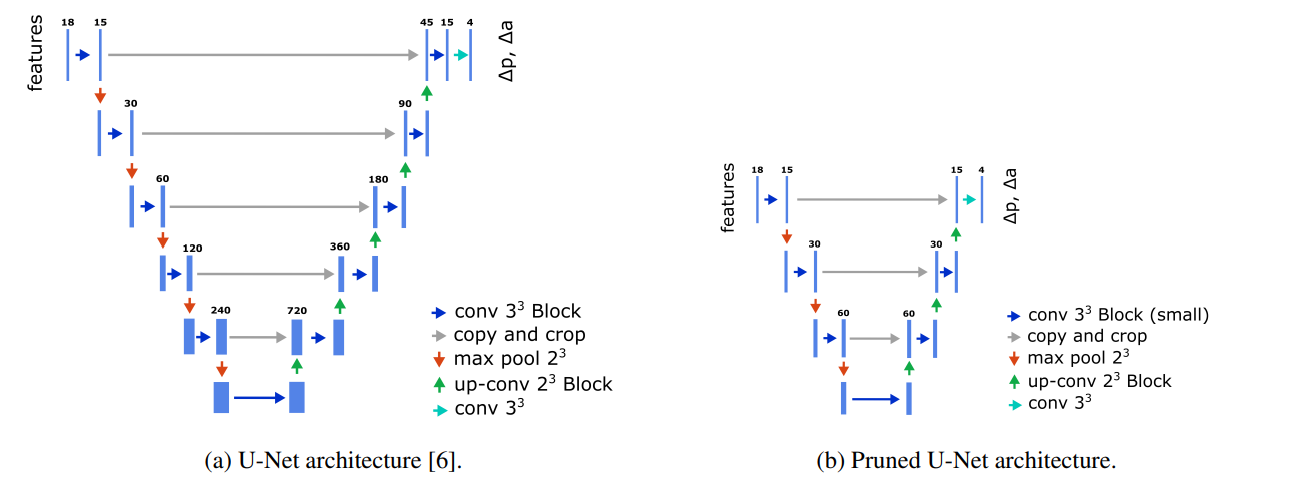

In the short version, concatenations are replaced by sums and 2 pooling stages have been removed. The output of the CNN is also mean-normalized.

An overview of a time step incrementation is displayed below :

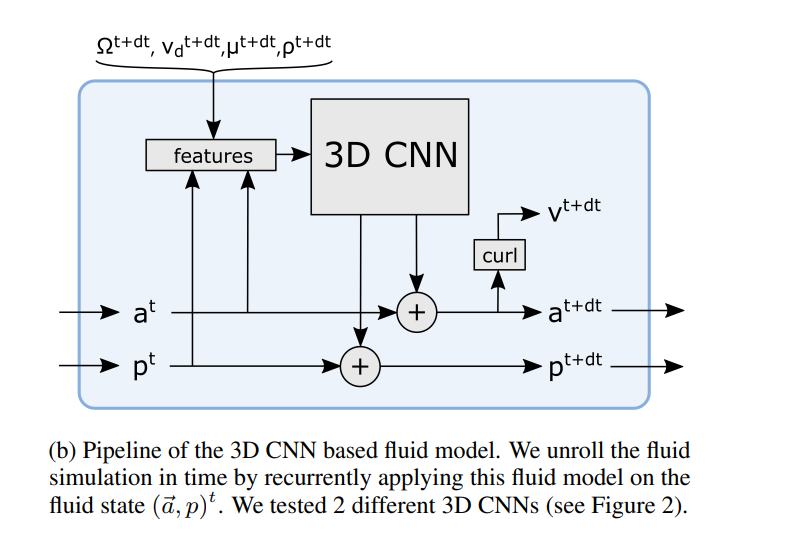

The following features are computed as inputs of the CNN model.

\begin{align*}
\text{Features} = p_t, \mathbf{a}_t, \nabla \times \mathbf{a}_t, \Omega_{t+dt}, \partial \Omega_{t+dt}, \Omega_{t+dt} \cdot \nabla \times \mathbf{a}_t, \Omega_{t+dt} \cdot p_t, \partial \Omega_{t+dt} \cdot \mathbf{v}_{t+dt}^d, \ln(\mu_{t+dt}), \ln(\rho_{t+dt}) \quad (14)
\end{align*}

## 3.4 A solver-free training

A big advantage of this method is also that data from simulation is not required for training. Instead, a pool of of initial states is created: $\{ \mathbf{a}_0^k, p_0^k, \Omega_0^k, (\mathbf{v}_d)_0^k, \mu_k, \rho_k \}_{k \in \text{pool}}$. 
The domain, its boundary conditions and and fluid parameters are randomized.

The randomized domains contain primitive shapes (boxes, balls etc.) in 128x64x64 voxels as show below:

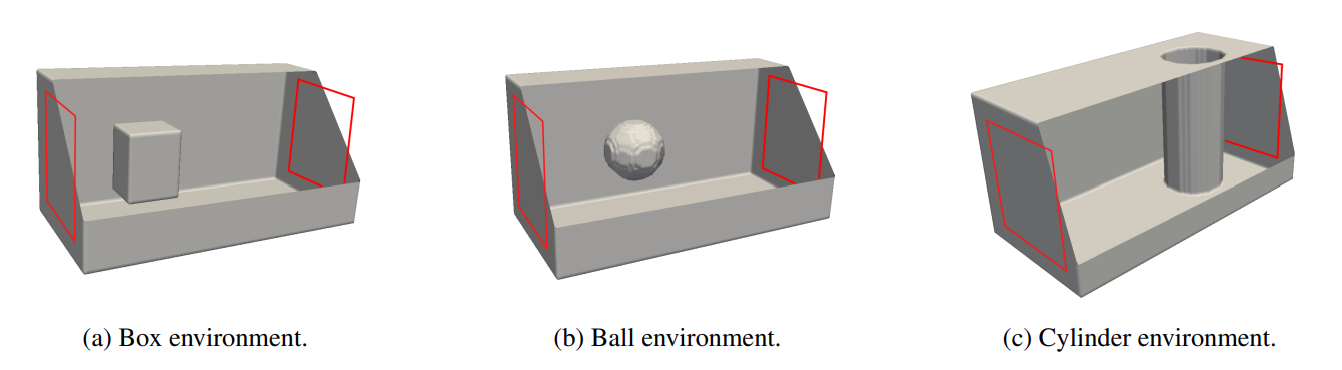

The red boxes are the inflow / outflow boundaries.
At the beginning, we set $\{ \mathbf{a}_0^k = 0$ and $p_0^k = 0\}$ for simplicity then for every training step, a random mini-batch is drow from the pool and fed into the network. Velocity and pressure fields are predicted and the physics-informed loss function, Equation (12), is calulated to update the weights of the network. 

The velocity potential and pressure fields predicted are then reused to make a new predictions. This way, the training pool is replaced with more and more realistic fluid states as the model becomes better.

The code and the installation guide to make the code work can be found on this [Git repository](https://github.com/wandeln/Teaching_Incompressible_Fluid_Dynamics_to_3D_CNNs/tree/main).
You may need a GPU to make it work.

Here are some visualiation of simulations for different fluids types:

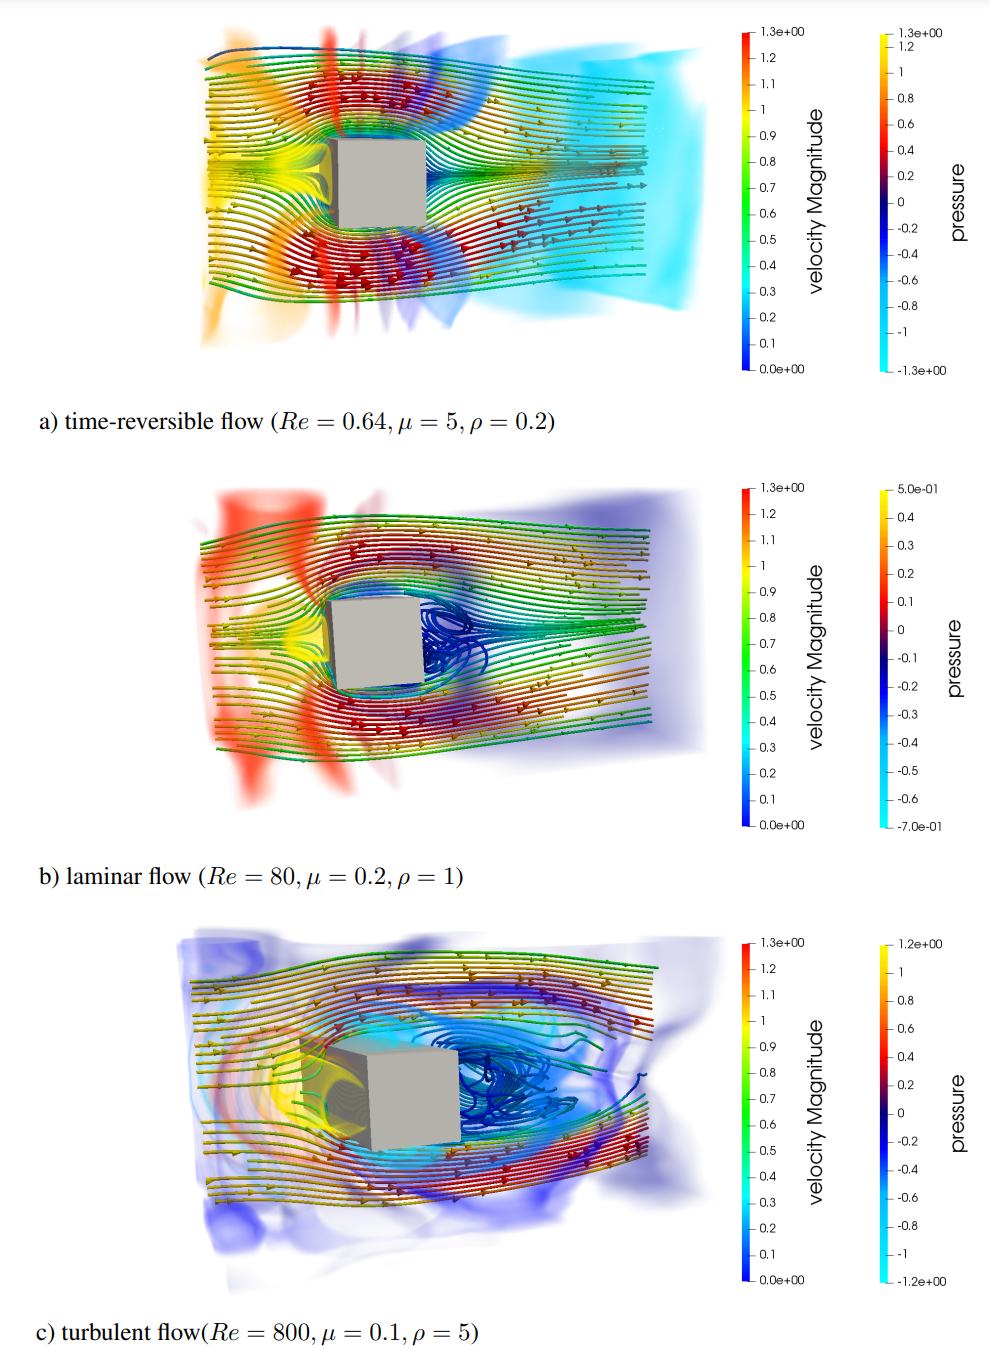


## 3.5 Performance results and comparison

The performance of both the U-Net and the pruned U_Net have been compared to Phiflow, a recent open-source fluid simulation package in the domain defined above. Performance have been assessed on different fluid characteristics in term of $L_p, L_b$ and $E[\|\nabla \cdot \mathbf{v}\|]$ where $E[\|\nabla \cdot \mathbf{v}\|]$ is the $L_2$ norm of the velocity divergence.

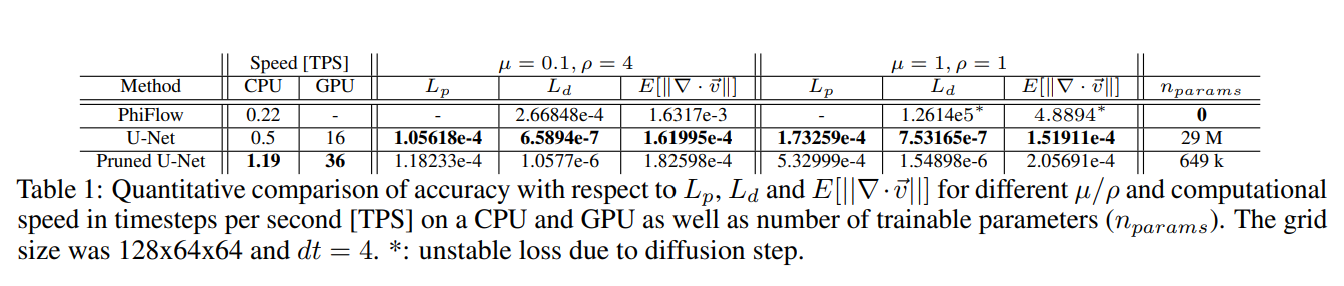

As you can see above, U-Net provides more accurate results and the small model is considerably faster with only slighly less accuracy making it suitable for real-time simulations.
Note that a direct comparison with Tompson et al. (first method introduced in the notebook) is impossible because this method only considers Eulerian fluid and do not handle viscosity. However, in terms of $E[\|\nabla \cdot \mathbf{v}\|]$, Nils Wandel et al.'s method indicates lower divergence of the velocity field. This is because the model predicts the potential field of velocity and not a Helmoltz projection step.

Moreover, this method allows to model Magnus effect (when a fluid streams around a rotating body) which plays a crucial role in sports like soccer and tennis. As you can see below from simulations:

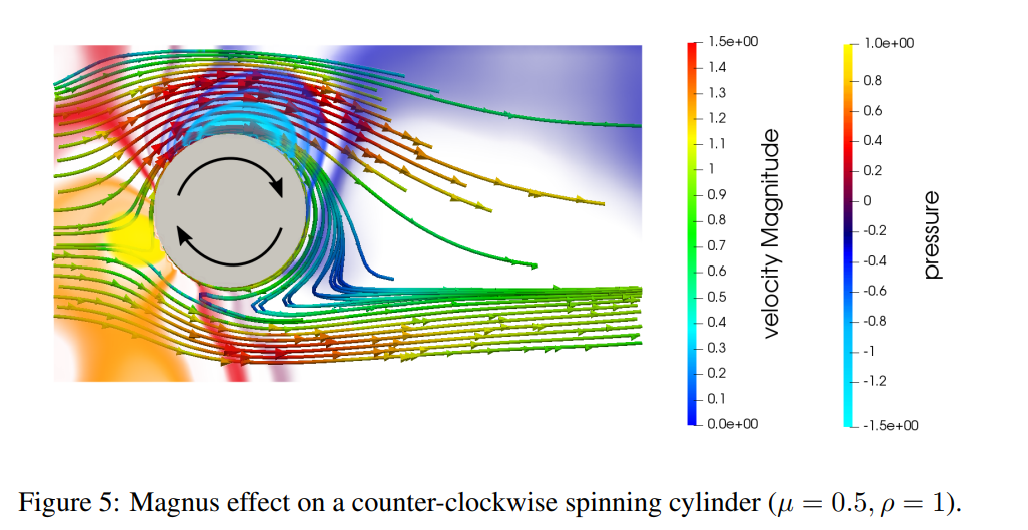

The model is also able to generelize to new domain geometries not contained in the training dataset. The model still manages to match boundary conditions, low divergence of the velocity field and predict plausible flow and pressure fields as you can see below:

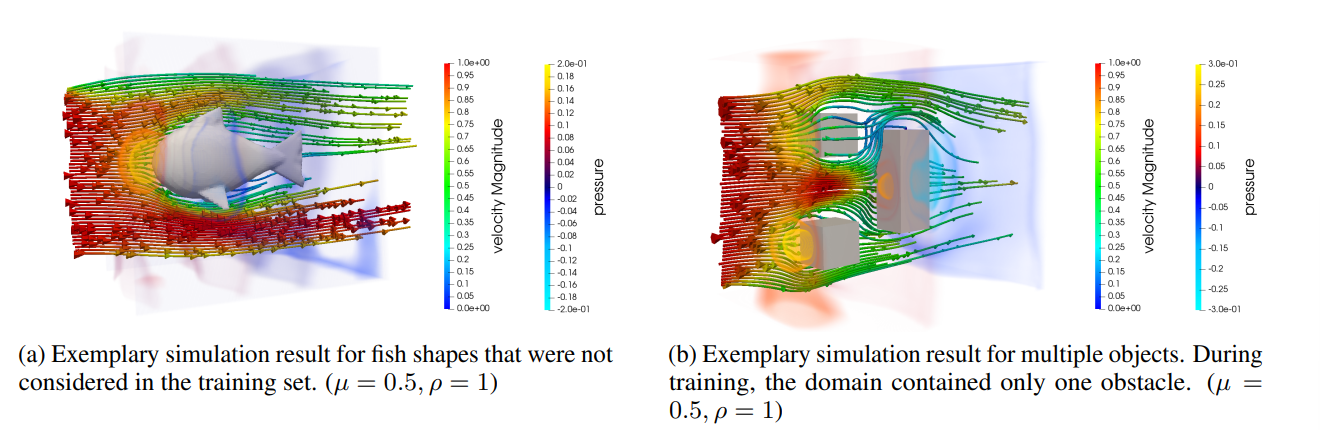

Regarding training, the model only need a few 500 timesteps to warm-it from $\{ \mathbf{a}_0^k, p_0^k, \Omega_0^k$ and reach good stability characteristics as you can see here:

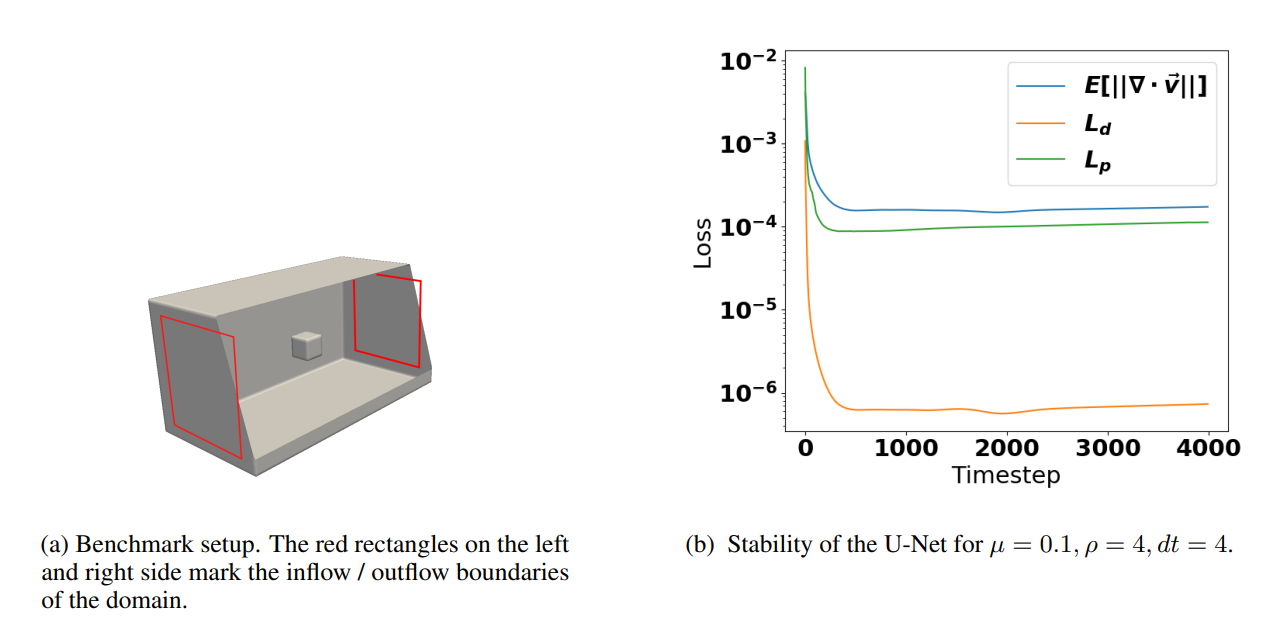


Here is a video of the simulation on various shape:

In [7]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/tKcYJaJtHJE?si=IY1DkMTn5vNlf1Th"
</iframe>

# Conclusion

You have seen why CNNs can be usefull and the two main ways of using them to solve Navier-Stokes equations (to solve the Poisson equation or as surrogate models).
Convolutional network can drastically improve computation times of Navier-Stokes equations and still produce realistic results (even with small models). This is promising for several use cases (movies, video games etc.).

However, there is no standard architecture today. It seems that the latest publications are moving in the direction of surrogate models. Each author proposes small improvements in terms of CNN architecture, loss or resolution algorithm.

## Sources

[1.] [Helmholtz-Hodge decomposition theorem](https://en.wikipedia.org/wiki/Helmholtz_decomposition)

[2.] Frédéric Gibou, Chohong Min and Hector Ceniceros [Finite Difference Schemes for Incompressible Flows on Fully Adaptive Grids](http://math.ewha.ac.kr/~chohong/publications/article_6_fdm_for_incompressible_flow.pdf)

[3.] Jonathan Tompson, Kristofer Schlachter, Pablo Sprechmann, and Ken Perlin. [Accelerating eulerian fluid simulation with convolutional networks.](https://arxiv.org/abs/1607.03597)

[4.] Nils Wandel, Michael Weinmann and Reinhard Klein. [TEACHING THE INCOMPRESSIBLE NAVIER-STOKES EQUATIONS TO FAST NEURAL SURROGATE MODELS IN 3D](https://arxiv.org/abs/2012.11893)


### Git repositories

FluidNet [3.] 
https://github.com/google/FluidNet/blob/master/README.md

U-Net [4.] https://github.com/wandeln/Teaching_Incompressible_Fluid_Dynamics_to_3D_CNNs/tree/main
